# 1. Data Ingestion and Preprocess


In [8]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

outcome_dict = {
'normal': 'normal',
'back': 'DoS',
'land': 'DoS',
'neptune': 'DoS',
'pod': 'DoS',
'smurf': 'DoS',
'teardrop': 'DoS',
'mailbomb': 'DoS',
'apache2': 'DoS',
'processtable': 'DoS',
'udpstorm': 'DoS',
'ipsweep': 'Probe',
'nmap': 'Probe',
'portsweep': 'Probe',
'satan': 'Probe',
'mscan': 'Probe',
'saint': 'Probe',
'ftp_write': 'R2L',
'guess_passwd': 'R2L',
'imap': 'R2L',
'multihop': 'R2L',
'phf': 'R2L',
'spy': 'R2L',
'warezclient': 'R2L',
'warezmaster': 'R2L',
'sendmail': 'R2L',
'named': 'R2L',
'snmpgetattack': 'R2L',
'snmpguess': 'R2L',
'xlock': 'R2L',
'xsnoop': 'R2L',
'worm': 'R2L',
'buffer_overflow': 'U2R',
'loadmodule': 'U2R',
'perl': 'U2R',
'rootkit': 'U2R',
'httptunnel': 'U2R',
'ps': 'U2R',
'sqlattack': 'U2R',
'xterm': 'U2R'
}

outcome_dict_numeric = {
"normal": 0.0,
"DoS": 1.0,
"Probe": 2.0,
"R2L": 3.0,
"U2R": 4.0
}
outcome_names = ["normal","DoS","Probe","R2L","U2R"]
outcome_names_int = [0.0,1.0,2.0,3.0,4.0]

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
  def __init__(self):
    super().__init__()

  def _transform(self, dataset):
    label_to_binary = udf(lambda name:outcome_dict_numeric[outcome_dict[name]])
    output_df = dataset.withColumn('outcome',label_to_binary(col('class'))).drop("class")
    output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
    output_df = output_df.drop('difficulty')
    return output_df


class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')


    # Stage for creating the outcome column representing whether there is attack
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline

## 2.1 Load the training and test dataframe using the pipeline

In [9]:
import findspark
findspark.init()
findspark.find()

import os
import sys

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("IntrusionDetectionProject") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)



In [10]:
nslkdd_df.printSchema()
nslkdd_df.show()


root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    0.0|
|(113,[1,13,14,17,...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    3.0|
|(113,[13,14,15,18...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    2.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [11]:
nslkdd_df_test.printSchema()
nslkdd_df_test.show(1)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|    1.0|
+--------------------+-------+
only showing top 1 row



## Random Forest Classifier For Benchmarking

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol='features', labelCol='outcome')

rf_model = rf.fit(nslkdd_df)

train_pred = rf_model.transform(nslkdd_df)
test_pred = rf_model.transform(nslkdd_df_test)

evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")

train_acc = evaluator.evaluate(train_pred)
test_acc = evaluator.evaluate(test_pred)

print(f"Train Acc: {train_acc}")
print(f"Test Acc: {test_acc}")

Train Acc: 0.9653100267517642
Test Acc: 0.705819730305181


Text(0.5, 25.722222222222214, 'Predicted')

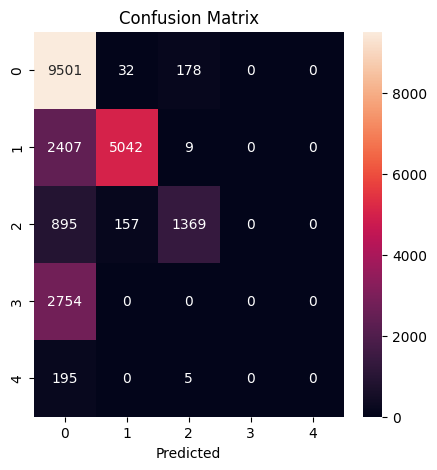

In [13]:
predictions_pd = test_pred.select('outcome', 'prediction').toPandas()

# import plt
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pd['outcome'], predictions_pd['prediction'])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')


In [14]:
# Perform a grid search to find the best hyperparameters
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [5, 10, 15])
                .addGrid(rf.maxBins, [20, 60])
                .addGrid(rf.numTrees, [5, 20, 50])
                .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(nslkdd_df)

train_pred = cv_model.transform(nslkdd_df)
test_pred = cv_model.transform(nslkdd_df_test)

train_acc = evaluator.evaluate(train_pred)
test_acc = evaluator.evaluate(test_pred)

print(f"Train Acc: {train_acc}")
print(f"Test Acc: {test_acc}")

Train Acc: 0.9984282346217046
Test Acc: 0.7429914833215047


Text(0.5, 25.722222222222214, 'Predicted')

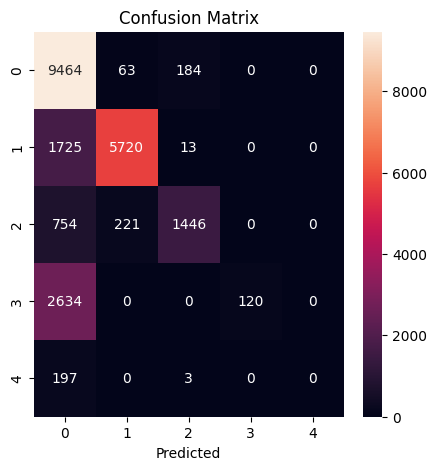

In [15]:
predictions_pd = test_pred.select('outcome', 'prediction').toPandas()

# import plt
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pd['outcome'], predictions_pd['prediction'])
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')